In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
import cv2
from glob import glob
import matplotlib.pyplot as plt

# Enable GPU usage
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

In [ ]:
# Function to apply sharpening
def sharpen_image(img):
    kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
    return cv2.filter2D(img, -1, kernel)

# Function to apply Gaussian Blur
def gaussian_blur(img):
    return cv2.GaussianBlur(img, (5, 5), 0)

# Custom preprocessing function
def preprocess_image(img):
    img = cv2.resize(img, (128, 128))
    img = sharpen_image(img)
    img = gaussian_blur(img)
    img = img / 255.0
    return img

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    preprocessing_function=preprocess_image
)

valid_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_image)
test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_image)

train_dir = "/kaggle/input/dataset/train"
valid_dir = "/kaggle/input/dataset/val"
test_dir = "/kaggle/input/dataset/test"

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(128, 128), batch_size=64, class_mode='binary')
valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(128, 128), batch_size=64, class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(128, 128), batch_size=64, class_mode='binary')

In [ ]:
def build_model():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(128, 128, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        layers.Flatten(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),

        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),

        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

model = build_model()
model.summary()

In [ ]:
# Early stopping to prevent overfitting
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Reduce learning rate when validation loss plateaus
lr_reduction = callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)

# Model checkpoint to save the best model
checkpoint = callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

callbacks_list = [early_stopping, lr_reduction, checkpoint]

In [ ]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=50,
    batch_size=64,
    callbacks=callbacks_list
)

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

model.save("oral_cancer_classifier.keras")

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
import random

# Get a random test image
test_images = glob(test_dir + "/*/*")
random_image = random.choice(test_images)

# Load and preprocess image
img = cv2.imread(random_image)
img = cv2.resize(img, (128, 128))
img = img / 255.0
img = np.expand_dims(img, axis=0)

# Predict
prediction = model.predict(img)
class_label = "OSCC" if prediction[0][0] > 0.5 else "Normal"

# Show the image
plt.imshow(cv2.cvtColor(cv2.imread(random_image), cv2.COLOR_BGR2RGB))
plt.title(f"Predicted: {class_label}")
plt.axis("off")
plt.show()

Num GPUs Available: 1
Found 4946 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 126 images belonging to 2 classes.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 16, 16, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,601,601 (82.40 MB)

 Trainable params: 21,598,145 (82.39 MB)

 Non-trainable params: 3,456 (13.50 KB)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


155/155 ━━━━━━━━━━━━━━━━━━━━ 181s 965ms/step - accuracy: 0.5221 - auc: 0.5270 - loss: 2.3648 - precision: 0.5198 - recall: 0.5221 - val_accuracy: 0.7667 - val_auc: 0.5148 - val_loss: 1.8898 - val_precision: 0.7667 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 84s 520ms/step - accuracy: 0.5611 - auc: 0.5783 - loss: 2.2738 - precision: 0.5730 - recall: 0.5521 - val_accuracy: 0.2333 - val_auc: 0.5505 - val_loss: 2.8609 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 91s 564ms/step - accuracy: 0.5576 - auc: 0.5856 - loss: 2.1904 - precision: 0.5575 - recall: 0.5743 - val_accuracy: 0.6917 - val_auc: 0.5912 - val_loss: 1.8766 - val_precision: 0.7619 - val_recall: 0.8696 - learning_rate: 1.0000e-04
Epoch 4/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 89s 548ms/step - accuracy: 0.5836 - auc: 0.6138 - loss: 2.1248 - precision: 0.5960 - recall: 0.5660 - val_accuracy: 0.3167 - val_auc: 0.5584

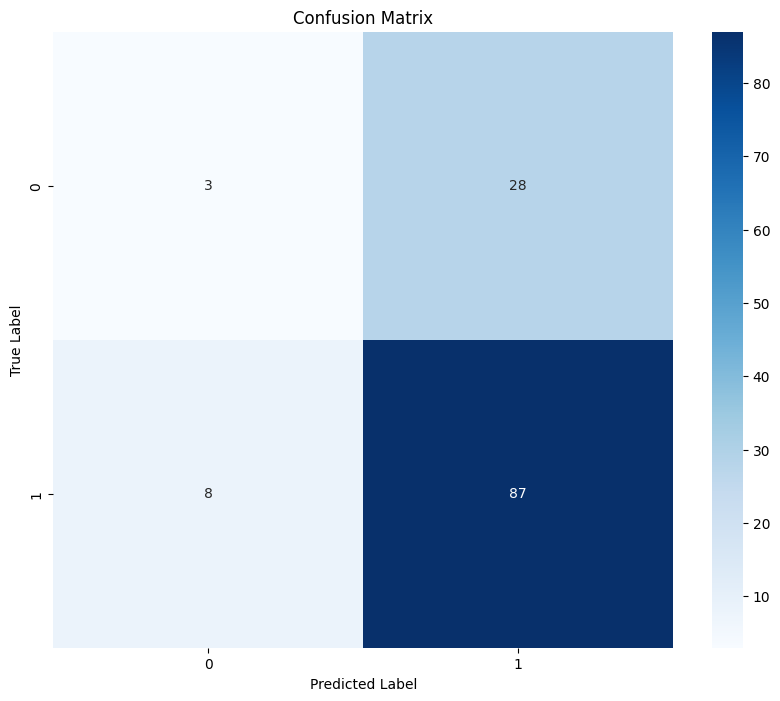


Classification Report:
              precision    recall  f1-score   support

      Normal       0.27      0.10      0.14        31
        OSCC       0.76      0.92      0.83        95

    accuracy                           0.71       126
   macro avg       0.51      0.51      0.49       126
weighted avg       0.64      0.71      0.66       126



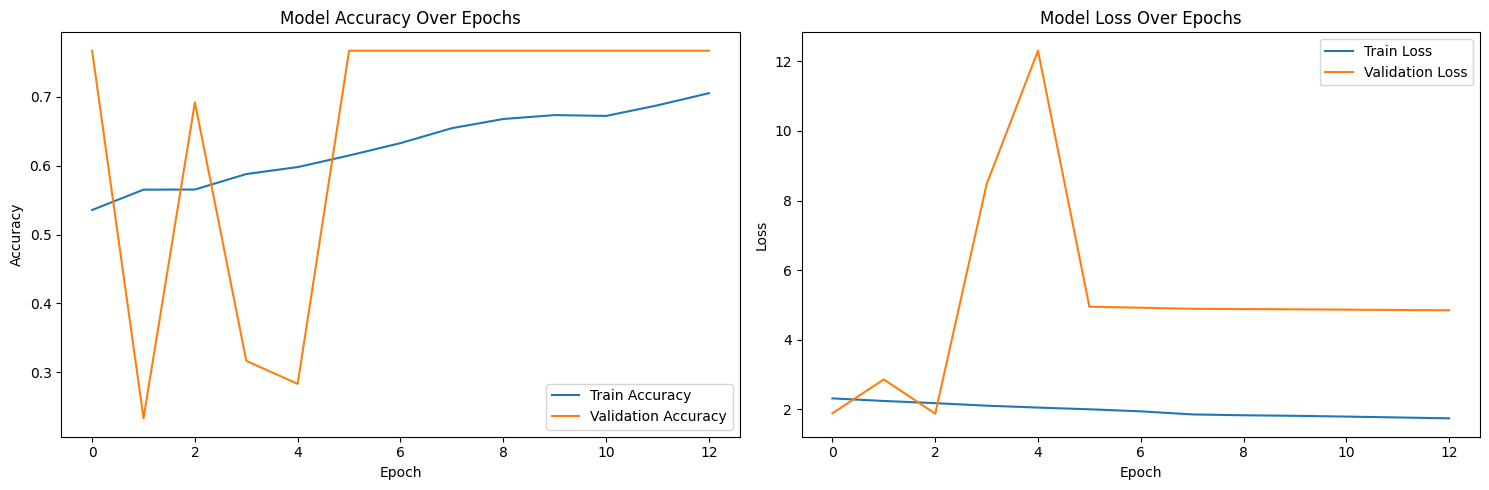

In [17]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
import cv2
from glob import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import random

# Enable GPU usage
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# Define augmentation functions
def sharpen_image(img):
    kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
    return cv2.filter2D(img, -1, kernel)

def gaussian_blur(img):
    return cv2.GaussianBlur(img, (5, 5), 0)

# Custom preprocessing function with random augmentation
def preprocess_image(img):
    img = cv2.resize(img, (128, 128))
    
    # Randomly apply either sharpening, gaussian blur, or no filter
    augment_choice = random.choice(['sharp', 'blur', 'none'])
    if augment_choice == 'sharp':
        img = sharpen_image(img)
    elif augment_choice == 'blur':
        img = gaussian_blur(img)
    
    img = img / 255.0
    return img

# Enhanced data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    preprocessing_function=preprocess_image
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

BATCH_SIZE = 32

train_dir = "/kaggle/input/dataset/train" 
valid_dir = "/kaggle/input/dataset/val" 
test_dir = "/kaggle/input/dataset/test"

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(128, 128), 
    batch_size=BATCH_SIZE, 
    class_mode='binary'
)
valid_generator = valid_datagen.flow_from_directory(
    valid_dir, 
    target_size=(128, 128), 
    batch_size=BATCH_SIZE, 
    class_mode='binary'
)
test_generator = test_datagen.flow_from_directory(
    test_dir, 
    target_size=(128, 128), 
    batch_size=BATCH_SIZE, 
    class_mode='binary',
    shuffle=False  # Important for confusion matrix
)

def build_improved_model():
    model = models.Sequential([
        # First Block - Initial features
        layers.Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(128, 128, 3)),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.3),

        # Second Block - Medium features
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.3),

        # Third Block - Complex features
        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.3),

        # Fourth Block - Fine details
        layers.Conv2D(512, (3,3), activation='relu', padding='same'),
        layers.Conv2D(512, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.3),

        # Dense layers
        layers.Flatten(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    
    return model

model = build_improved_model()
model.summary()

# Enhanced callbacks
callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_loss',
        save_best_only=True
    )
]

# Train model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=100,  # Increased epochs with early stopping
    callbacks=callbacks_list
)

# Evaluate model
test_results = model.evaluate(test_generator)
print("\nTest Results:")
for metric_name, value in zip(model.metrics_names, test_results):
    print(f"{metric_name}: {value:.4f}")

# Generate predictions for confusion matrix
predictions = model.predict(test_generator)
y_pred = (predictions > 0.5).astype(int)
y_true = test_generator.classes

# Create and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'OSCC']))

# Plot training history
plt.figure(figsize=(15, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Save model
model.save("improved_oral_cancer_classifier.keras")